### 04. PyTorch Custon Datasets Video Notebook


We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets

## Domain libraries
Depending on what you're working on vision,text,audio,recommendation, you'll want to look each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.



#### 0. Importing PyTorch and Setting up device - agnostic code

In [1]:
import torch
from torch import nn

# Note : PyTorch 1.10.0 + is required for this course
torch.__version__

'2.5.1'

In [2]:
# Setup divice- agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Get Data
Our Dataset is a subset of the food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset start with 3 classes of food and only 10% of the image. (75 training, 25 testing. )

When starting out ML projects, it's important to try on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# IF image folder dosen't exist, download it and prepare it....
if image_path.is_dir():
  print(f'{image_path} directory already exist skipping download ... ')
else:
    print(f'{image_path} directory does not exist, creating one ... ')
    image_path.mkdir(parents = True,exist_ok = True)

# Download Pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip','wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip_ref:
  print('Unzipping pizza, steak and sushi data....')
  zip_ref.extractall(image_path)


data/pizza_steak_sushi directory does not exist, creating one ... 
Unzipping pizza, steak and sushi data....


### 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  '''walks through dir_path returning its contents.'''

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [6]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir
image_path

PosixPath('data/pizza_steak_sushi')

### 2.1  Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL  
5. We'll then show the image and print meta data.


data/pizza_steak_sushi/train/steak/1849463.jpg
Random image path :data/pizza_steak_sushi/train/steak/1849463.jpg
Image class: steak
Image height: 512
Image width: 512


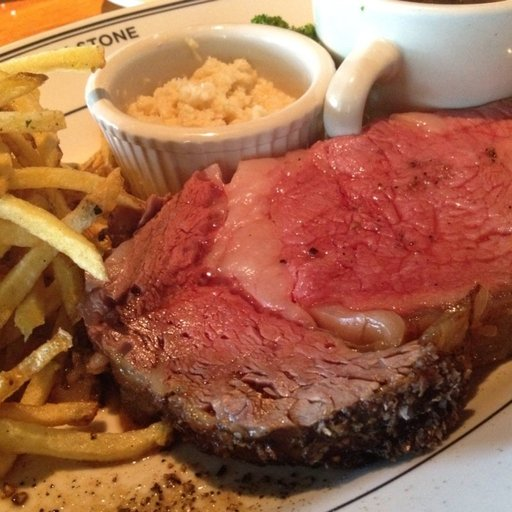

In [7]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

#3. Get the image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.name

#4 Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path :{random_image_path}")
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

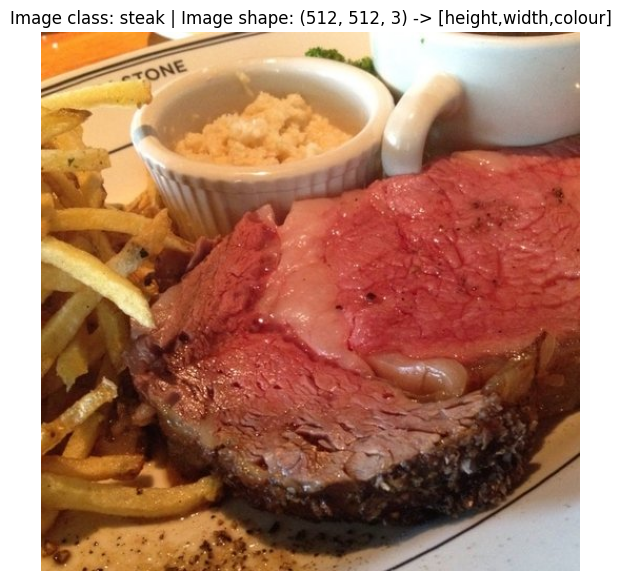

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the img into an array

img_as_array = np.asarray(img)


# Plot the image with matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,colour]')
plt.axis(False)

### Transforming data

Before we can use our image data with PyTorch
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `DataLoader`.


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.
https://pytorch.org/vision/stable/transforms.html

In [10]:
from typing_extensions import dataclass_transform
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size = (64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image to a torch.Tensor
    transforms.ToTensor()

])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

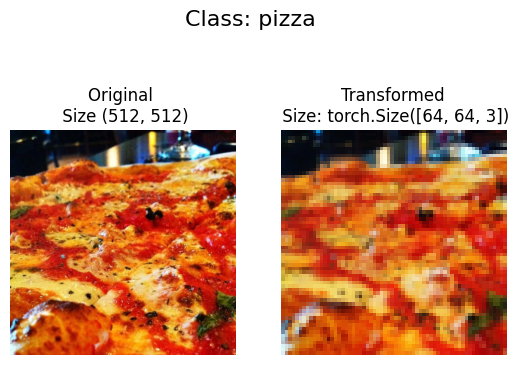

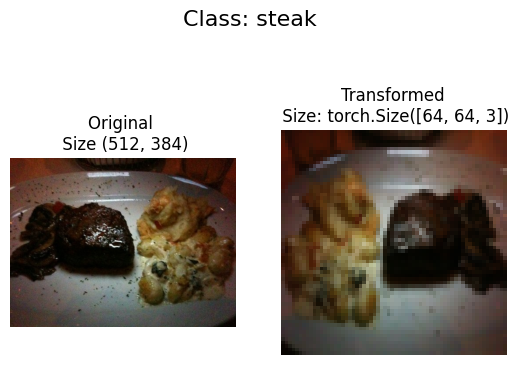

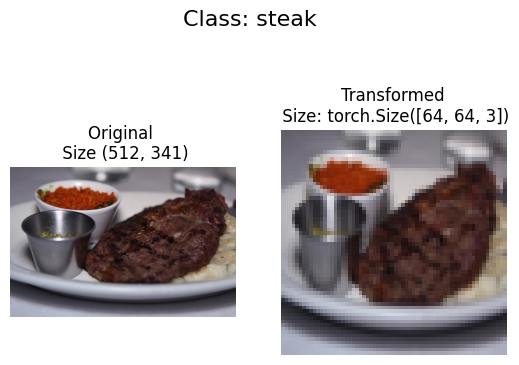

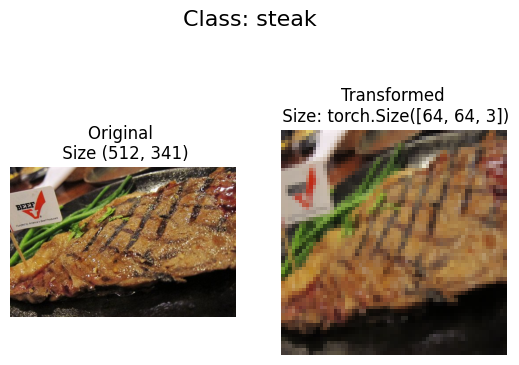

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed = None):
  '''
  Selects random images from a path of images and loads/transforms
   them then plots the original vs the transformed version
   '''
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows = 1,ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\n Size: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.name}',fontsize= 16)


plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=4,
                        seed = 42)




### 4. Option 1: Loading image data using `ImageFolder`


We can load image classification data using `torchvision.datasets.ImageFolder`

In [13]:
# Use ImageFolder to create dataset (s)

from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform = None) # a transform for the label/ Target

test_data = datasets.ImageFolder(root = test_dir,
                                transform = data_transform, # a transform for the data
                                target_transform = None) # a transform for the label/ Target


train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [18]:
# Index on the train_data Dataset to get a single image and label

img , label = train_data[0]
print(f'Image tensor: \n {img}')
print('\n')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype ; {type(label)}')


Image tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

Original shape : torch.Size([3, 64, 64]) -> [color channels, height, width]
Changed Shape : torch.Size([64, 64, 3]) -> [height,wdth,color channels]


Text(0.5, 1.0, 'pizza')

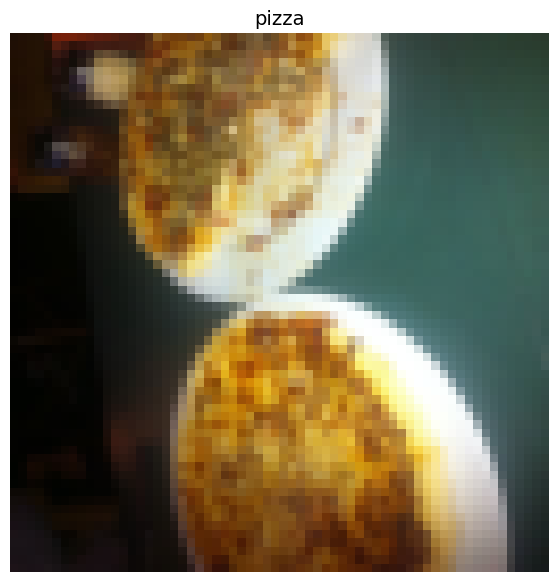

In [19]:
# Rearrange the order of dimensions

img_permute = img.permute(2,1,0)

# Print out differnet shapes

print(f'Original shape : {img.shape} -> [color channels, height, width]' )
print(f'Changed Shape : {img_permute.shape} -> [height,wdth,color channels]')


# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn loaded images into DataLoader's


A `Data Loader` is going to help us turn our `Dataset's` into iterables and we can custimise the `batch_size`so our model can see  `batch_size` so our model can see `batch_size` images at a time.

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = False)


In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img,label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like

print(f'Image shape: {img.shape} -> [batch_size, color_channels,height,width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels,height,width]
Label shape: torch.Size([1])


### 5. Option 2 : Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros :
* Can create a `Dataset` out of almost anything
* Not Limited to PyTorch pre-build `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn'r mean it will work..

* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues



In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List



In [24]:
# Instance torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx,


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a fucntion to:
1. Get the class name using `os.scandir()` to traverse a target directory (ideally)
the directory is in standard image classification
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.


In [25]:
# Setup path for target directory

target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple [List[str], Dict[str,int]] :
  "Find the classes folder names in a target directory"
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

# 2 Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could'nt find any classes in {directory}.... please check file structure")

  #3 Create a dictionary of index labels
  class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
  return classes,class_to_idx

In [27]:
classes,idx  = find_classes(target_directory)
classes,idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * clas_to_idx - a dict of the target classes mapped to integer labels
4. Create a fucntion to `load_images()` , this function will open an image
5. Overwrite the '__len()__' method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [28]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [29]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)


In [31]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x14c7aaaa0>,
 <__main__.ImageFolderCustom at 0x14c7aa4a0>)

In [32]:
len(train_data),len(train_data_custom)

(225, 225)

In [33]:
len(test_data),len(test_data_custom)

(75, 75)

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)


True
True


### 5.3 Create a function to display ramdom images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the ramdom seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib
7. Make sure the dimension of our images line up with matplotlib (HWC)

In [36]:
#  Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n: int= 10,
                          display_shape:bool = True,
                          seed: int = None):
  # 2 Adjust display if n is too high
  if n> 10:
    n= 10
    display_shape = False
    print(f"For display, purpose, n should'nt be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  #4 Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  #5. Setup plot
  plt.figure(figsize = (16,8))

  # 6. Loop through random indexes and plot them through  matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]


    #7  Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [colour_channels,height,width] -> [height,width,colour_channels]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'{classes[targ_label]}'

      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
    plt.title(title)







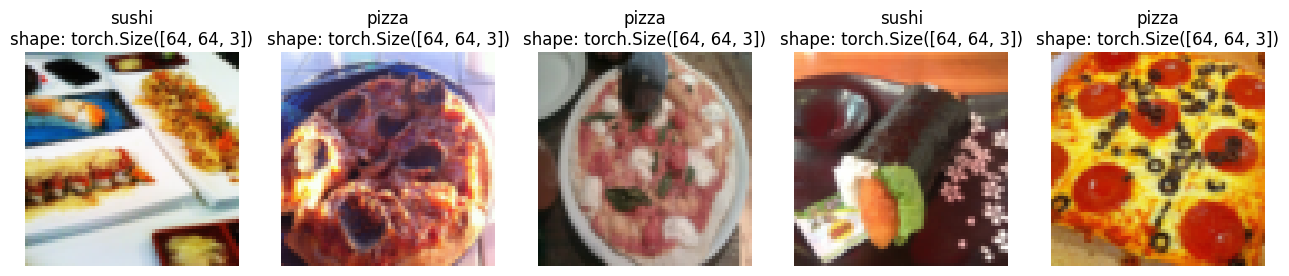

In [37]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                          classes = class_names,
                          n= 5,
                          seed= 42)

For display, purpose, n should'nt be larger than 10, setting to 10 and removing shape display.


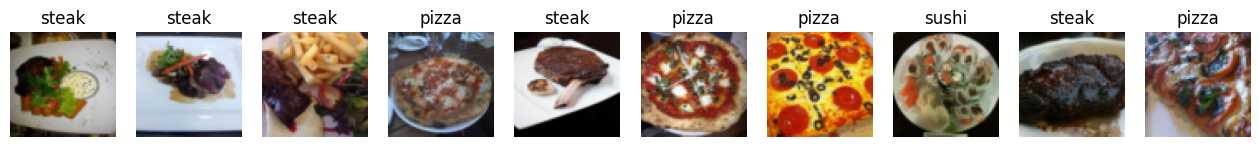

In [38]:
# Display random images from the ImageFolderCustom created Dataset
display_random_images(dataset=train_data_custom,
                          classes = class_names,
                          n= 30,
                          seed= None)

### 5.4 Turn custom loaded images into DataLoader's

In [39]:
from torch.utils.data import DataLoader
BATH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                      batch_size = BATH_SIZE,
                                      num_workers = NUM_WORKERS,
                                      shuffle =True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                      batch_size = BATH_SIZE,
                                      num_workers = NUM_WORKERS,
                                      shuffle =False)

train_dataloader_custom,test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x14d17fa90>,
 <torch.utils.data.dataloader.DataLoader at 0x14d3eba00>)

In [42]:
# # Get image and label from custom dataloader

# img_custom, label_custom = next(iter(train_dataloader_custom))

# # Print out the shape
# img_custom.shape,label_custom.shape

### 6 Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

In case of image data, this may mean applying various image transformations to the training images.

This pratice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the levels...

Blog post :https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy=%20improvements

In [43]:
# let's look at trivialaugment - https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.TrivialAugmentWide.html#torchvision.transforms.v2.TrivialAugmentWide
from torchvision import transforms

train_transform = transforms.Compose(
    [
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()]
)

test_transform = transforms.Compose(
    [
        transforms.Resize (size = (224,224)),
        transforms.ToTensor()
    ]
)





In [44]:
image_path

PosixPath('data/pizza_steak_sushi')

In [45]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [46]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

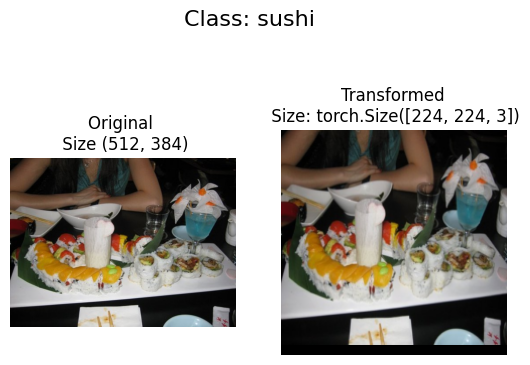

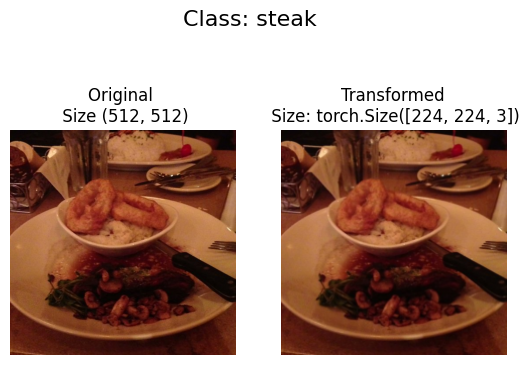

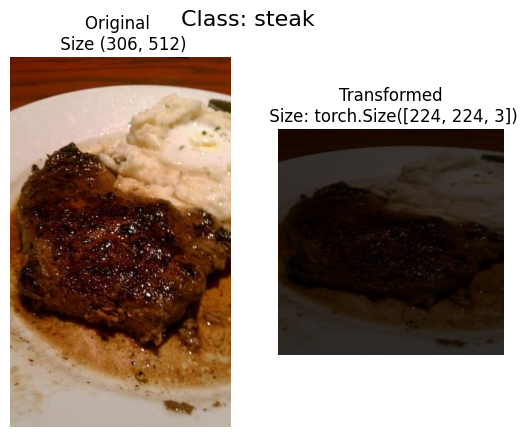

In [47]:
# Plot random transformed images
plot_transformed_images(image_paths = image_path_list,
                        transform = train_transform,
                        n=3,
                        seed = None)

### 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website : https://poloclub.github.io/cnn-explainer/


### 7.1 Create transforms and loading data for Model 0

In [48]:
# Create simple transform
simple_transform = transforms.Compose (
    [
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()]
)

In [49]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# Turn the dataets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size an number of works
BATCH_SIZE = 32
NUM_WORKERS  = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)


test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                     num_workers = NUM_WORKERS)



### 7.2 Create TinyVGG Model Class

In [50]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

### 7.3 Try a forward pass on a single image (to test the model)


In [64]:
# get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [65]:
#Try a forward pass
model_0(image_batch.to(device))


tensor([[-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02, -7.8815e-05, -8.3651e-02],
        [-2.9163e-02

#### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [66]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
batch_size = 32
summary(model = model_0,input_size = (batch_size,3,64,64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

### 7.5 Creating train and test loop functions



In [67]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [68]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` funtion to combine train_step() and test_step()

In [69]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

#### 7.7 Train and evaluate model 0

In [57]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:07<10:04, 67.14s/it]

Epoch: 1 | train_loss: 1.1025 | train_acc: 0.2773 | test_loss: 1.3041 | test_acc: 0.1979


 20%|██        | 2/10 [02:16<09:07, 68.42s/it]

Epoch: 2 | train_loss: 1.1093 | train_acc: 0.2812 | test_loss: 1.0947 | test_acc: 0.5417


 30%|███       | 3/10 [03:27<08:07, 69.66s/it]

Epoch: 3 | train_loss: 1.0961 | train_acc: 0.3867 | test_loss: 1.1040 | test_acc: 0.1979


 40%|████      | 4/10 [04:36<06:56, 69.38s/it]

Epoch: 4 | train_loss: 1.1035 | train_acc: 0.2930 | test_loss: 1.1137 | test_acc: 0.1979


 50%|█████     | 5/10 [05:49<05:53, 70.70s/it]

Epoch: 5 | train_loss: 1.1055 | train_acc: 0.2930 | test_loss: 1.1172 | test_acc: 0.1979


 60%|██████    | 6/10 [07:03<04:46, 71.70s/it]

Epoch: 6 | train_loss: 1.1037 | train_acc: 0.2930 | test_loss: 1.1113 | test_acc: 0.1979


 70%|███████   | 7/10 [08:14<03:35, 71.72s/it]

Epoch: 7 | train_loss: 1.1004 | train_acc: 0.2930 | test_loss: 1.1035 | test_acc: 0.1979


 80%|████████  | 8/10 [09:26<02:23, 71.53s/it]

Epoch: 8 | train_loss: 1.0982 | train_acc: 0.2852 | test_loss: 1.1035 | test_acc: 0.2604


 90%|█████████ | 9/10 [10:39<01:12, 72.15s/it]

Epoch: 9 | train_loss: 1.0967 | train_acc: 0.3867 | test_loss: 1.1078 | test_acc: 0.1979


100%|██████████| 10/10 [11:53<00:00, 71.40s/it]

Epoch: 10 | train_loss: 1.0980 | train_acc: 0.2930 | test_loss: 1.1145 | test_acc: 0.1979
Total training time: 713.964 seconds


In [58]:
model_0_results

{'train_loss': [1.1024748980998993,
  1.1092517524957657,
  1.096106693148613,
  1.1034822314977646,
  1.1055050194263458,
  1.10368612408638,
  1.1003797203302383,
  1.0981763154268265,
  1.09669890999794,
  1.0979638695716858],
 'train_acc': [0.27734375,
  0.28125,
  0.38671875,
  0.29296875,
  0.29296875,
  0.29296875,
  0.29296875,
  0.28515625,
  0.38671875,
  0.29296875],
 'test_loss': [1.3040795922279358,
  1.0947026014328003,
  1.1040465434392293,
  1.113749623298645,
  1.1171954075495403,
  1.1113157272338867,
  1.1034987767537434,
  1.1035287380218506,
  1.1077930529912312,
  1.1144999663035076],
 'test_acc': [0.19791666666666666,
  0.5416666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666]}

### 7.8 Plot the loss curves of modle 0
A **loss curve**  is a way of tracking your model over time

For more on loss curves visit : https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

In [59]:
# Get the model_0 keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

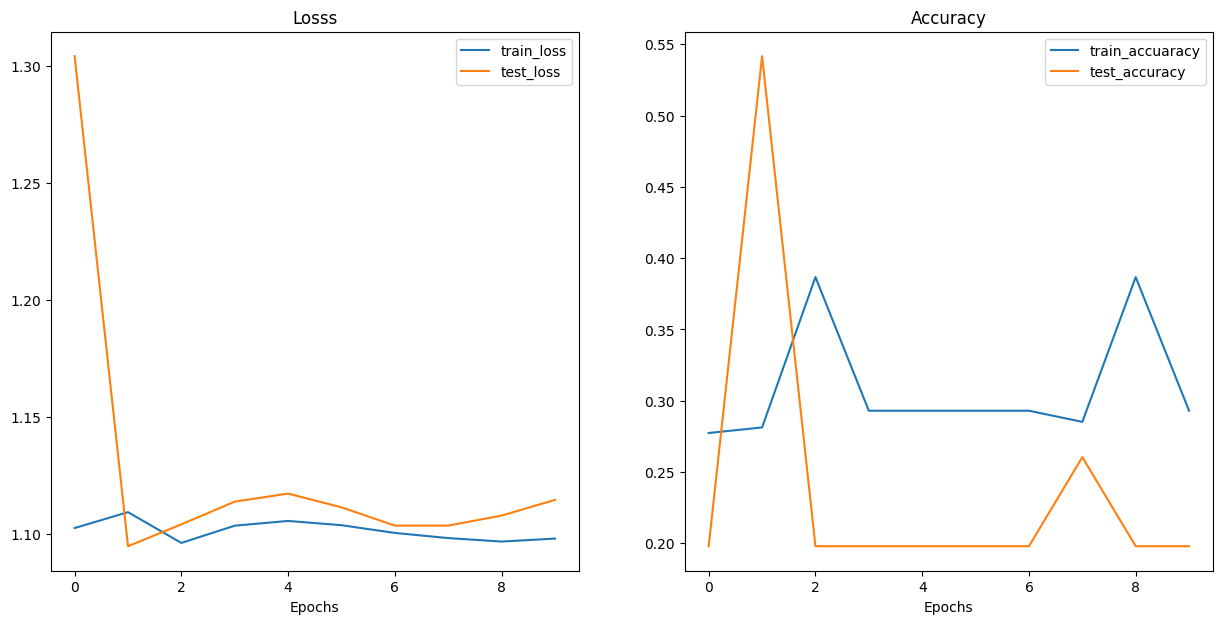

In [60]:
def plot_loss_curves(results:Dict[str,List[float]]):
  """Plots training curvers of a results dictionary. """
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy= results['test_acc']

  #3 Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize = (15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label = 'train_loss')
  plt.plot(epochs,test_loss,label = 'test_loss')
  plt.title('Losss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label = 'train_accuaracy')
  plt.plot(epochs,test_accuracy,label = 'test_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend()


plot_loss_curves(results= model_0_results)


# 8 What should an ideal loss curve should look like ?
 https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

 A Loss curve is one of the most helpful way to troubleshoot a model

### 9  Model 1 :Tiny Vgg with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.



### 9.1 Create transform with data augmentation

In [61]:
# Crate training transform with TriviailAugment
from torchvision import transforms
train_trainsform_trivial = transforms.Compose([
                                                transforms.Resize (size = (64,64)),
                                                transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                                transforms.ToTensor()

])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
])



### 9.2 Create train and test `Dataset's` and `DataLoader` with data augmentation

In [62]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_trainsform_trivial)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)


In [63]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
trian_dataloader_augmented = DataLoader (dataset = train_data_augmented,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True,
                                         num_workers = NUM_WORKERS)

test_data_Loader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle =True,
                                     num_workers = NUM_WORKERS)



### 9.3 Construct and Train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [70]:
# Create model_1 and send it to the target devcie

torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

Wonderful! Now we've a model and dataloaders, let's create a loss function and optimizer and call upon our `train()` function to train and evaluate our model

In [71]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epocs
NUM_EPOCHS = 10

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr = 0.001)
# Start the timer
from timeit import default_timer as tiemr
start_time = timer()

# Train_Model 1
model_1_results = train(model= model_1,
                        train_dataloader = trian_dataloader_augmented,
                        test_dataloader = test_data_Loader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time for model_1:  {end_time - start_time:.3f} seconds')





 10%|█         | 1/10 [01:08<10:16, 68.45s/it]

Epoch: 1 | train_loss: 1.1016 | train_acc: 0.2500 | test_loss: 1.0986 | test_acc: 0.2604


 20%|██        | 2/10 [02:20<09:26, 70.79s/it]

Epoch: 2 | train_loss: 1.0916 | train_acc: 0.4258 | test_loss: 1.0999 | test_acc: 0.3400


 30%|███       | 3/10 [03:29<08:08, 69.74s/it]

Epoch: 3 | train_loss: 1.1098 | train_acc: 0.3047 | test_loss: 1.0974 | test_acc: 0.3598


 40%|████      | 4/10 [04:42<07:05, 70.98s/it]

Epoch: 4 | train_loss: 1.0876 | train_acc: 0.4258 | test_loss: 1.0936 | test_acc: 0.3598


 50%|█████     | 5/10 [05:53<05:56, 71.21s/it]

Epoch: 5 | train_loss: 1.1110 | train_acc: 0.3047 | test_loss: 1.0977 | test_acc: 0.3400


 60%|██████    | 6/10 [07:02<04:40, 70.20s/it]

Epoch: 6 | train_loss: 1.1065 | train_acc: 0.3047 | test_loss: 1.0989 | test_acc: 0.3598


 70%|███████   | 7/10 [08:13<03:31, 70.65s/it]

Epoch: 7 | train_loss: 1.1017 | train_acc: 0.3047 | test_loss: 1.0998 | test_acc: 0.3201


 80%|████████  | 8/10 [09:25<02:21, 70.93s/it]

Epoch: 8 | train_loss: 1.0962 | train_acc: 0.4258 | test_loss: 1.0957 | test_acc: 0.3201


 90%|█████████ | 9/10 [10:35<01:10, 70.84s/it]

Epoch: 9 | train_loss: 1.0976 | train_acc: 0.3047 | test_loss: 1.0936 | test_acc: 0.3002


100%|██████████| 10/10 [11:45<00:00, 70.57s/it]

Epoch: 10 | train_loss: 1.0969 | train_acc: 0.2344 | test_loss: 1.0904 | test_acc: 0.4025
Total training time for model_1:  705.714 seconds


### 9.4 Plot the loss curvers of model 1

A loss curve helps you evaluate your models performance overtime


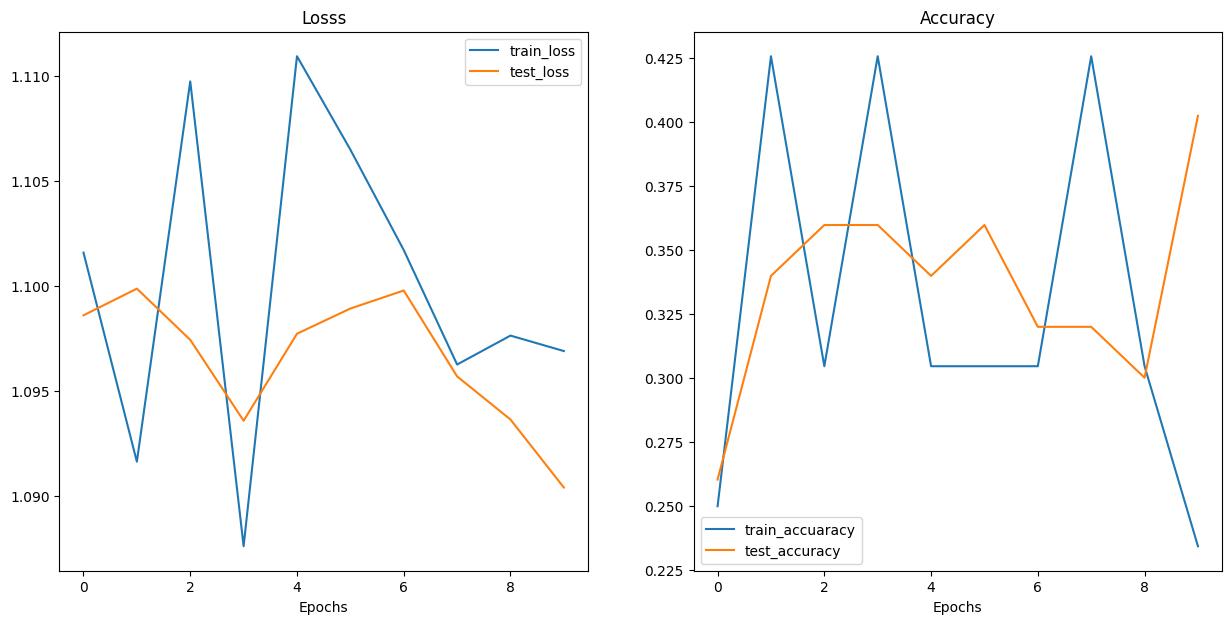

In [72]:
plot_loss_curves(results= model_1_results)

### 10 . Compare model results

After evaulating our modelling experiments on thier own, it's important to compare them to each other

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases https://wandb.ai/site/
4. MLFloe - https://mlflow.org/

In [73]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

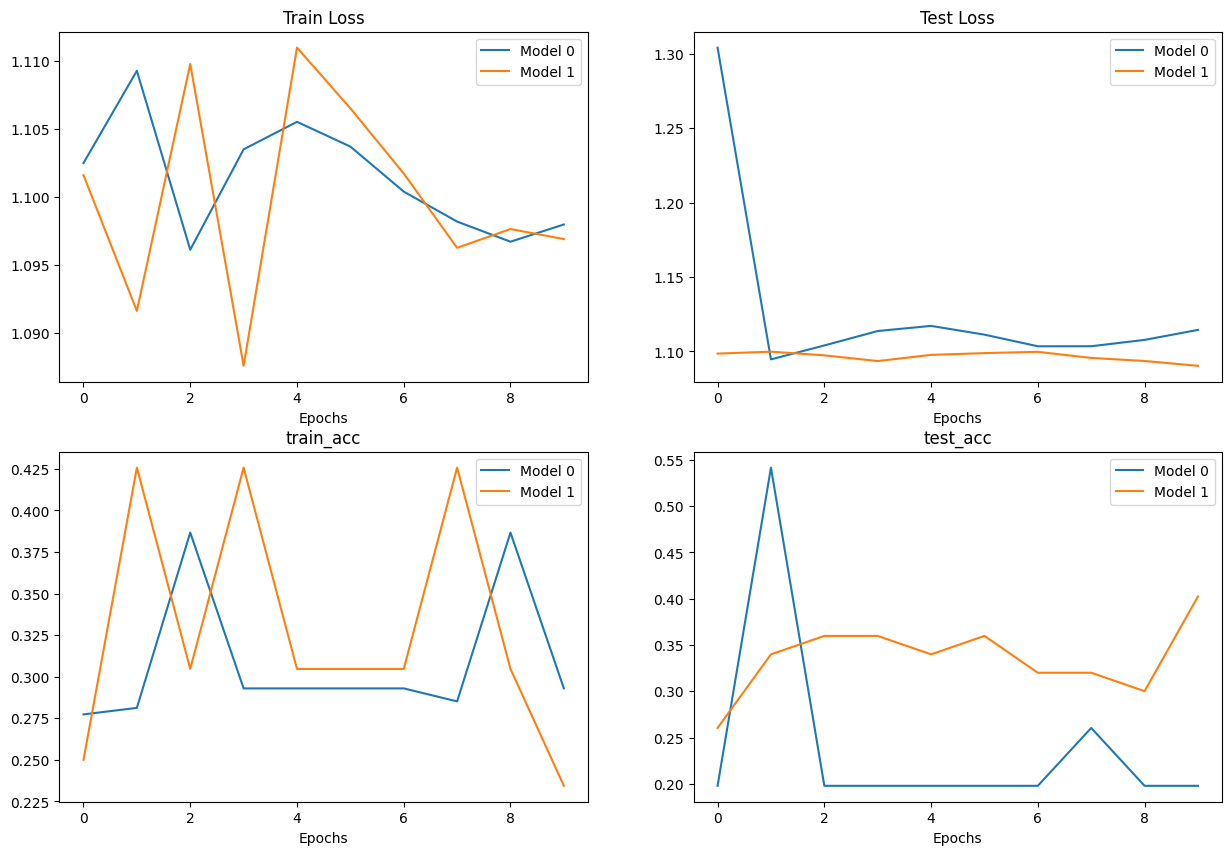

In [74]:
# Setup a plot
plt.figure(figsize= (15,10))

# Get num of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df['train_loss'],label = 'Model 0')
plt.plot(epochs,model_1_df['train_loss'],label = 'Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df['test_loss'],label = 'Model 0')
plt.plot(epochs,model_1_df['test_loss'],label = 'Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()



# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df['train_acc'],label = 'Model 0')
plt.plot(epochs,model_1_df['train_acc'],label = 'Model 1')
plt.title('train_acc')
plt.xlabel('Epochs')
plt.legend()


# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df['test_acc'],label = 'Model 0')
plt.plot(epochs,model_1_df['test_acc'],label = 'Model 1')
plt.title('test_acc')
plt.xlabel('Epochs')
plt.legend()




### 11. Making a prediction on a custom image

Although we've trained a model on a custom data...how do yuo make a prediction on a sample\image that's not in either training and testing dataset.

In [75]:
# Download custom image
import requests

# Setup custom image path

custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it dosen't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    # When downloading from GitHub, need to use the 'raw' file link
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exist skipping download')


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on

* In tensor form with datatype (torch.float32)
* of shape 64x64x3
* on the right device


In [76]:
import torchvision
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

print(f'Custom image tensor: \n {custom_image_uint8}')
print(f'Custom image shape: \n {custom_image_uint8.shape}')
print(f'Custom image datatype: \n {custom_image_uint8.dtype}')

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: 
 torch.Size([3, 4032, 3024])
Custom image d

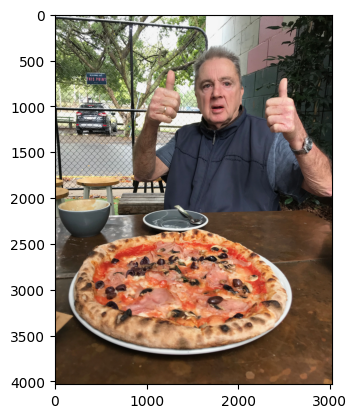

In [77]:
plt.imshow(custom_image_uint8.permute(1,2,0))

#### 11.2 Making a prediction on a cuastom image with a trained PyTorch model

In [78]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8)


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

In [ ]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
  model_1(custom_image)

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
# Create transform pipline to resize the image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                            transforms.Resize(size = (64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# This will error no batch size
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed)

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))
  print(custom_image_pred)

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3x64x64) with a batch size... (1,3,64,64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilites
custom_image_pred_probs = torch.softmax(custom_image_pred,dim = 1)
custom_image_pred_probs

In [ ]:
# Convert the prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim =1).cpu()
custom_image_pred_labels =  class_names[custom_image_pred_labels]
custom_image_pred_labels


### 11.3 Putting custom image prediction together building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path : str,
                        class_names : List[str] = None,
                        transform = None,
                        device = device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction. """

  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Device the image pixel values by 255 t get them between [0,1]
  target_image = target_image/255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on the eval/inference mode and make prediction mode

  model.eval()
  with torch.inference_mode():
    # Add an extra dimenstion to the image (this is the batch dimension e.g our model will predict on batches on 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a predictiom on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device


  # Convert the logis -> prediction probabilites
  target_image_pred_probs = torch.softmax(target_image_pred,dim = 1)


  # Convert prediction probabilites -> prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs,dim = 1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove batch dimension and rearrange shape to be HWC

  if class_names:
    title = f'Pred: {class_names[target_image_pred_labels.cpu()]} |  Prob : {target_image_pred_probs.max().cpu():.3f}'
  else:
    title = f'Pred: {target_image_pred_labels} | Prob {target_image_pred_probs}'

  plt.title(title)
  plt.axis(False)

In [ ]:
# Pred on our custom data
pred_and_plot_image(model = model_0,
                        image_path = custom_image_path,
                        class_names = class_names,
                        transform =  custom_image_transform,
                        device = device)